# PYRAWS - L0 API demonstration.

This notebook is to show and demonstrate the use of Application Program Interface (API) developed in the frame of the `PYRAWS` project to open and process `Sentinel-2 Raw data`, corresponding to a decompressed version of [Sentinel-2 L0 data](https://sentinel.esa.int/documents/247904/685211/sentinel-2-products-specification-document) with additional metada. <br> The API are demonstrated on the `Temperature Hotspots RAW Sentinel-2 (THRAWS)` dataset. <br>
We will introduce the use of the `Raw_event` and `raw_granule` classes to process `Raw granules` and `Raw events` containing images of volcanic eruptions. It will show how to stack different `Raw granules` acquired during the movement of the satellite along track and how to perform a coarse onboard coregistration of `Raw` bands. <br> Furthermore, it will introduce the APIs to extract specific bands coordinates. <br>
Finally, after introducing the equivalent `L1C_tiles` and `L1C_event`, the notebook will show the API to mosaic the `L1C`tiles and crop them around the specific `raw_granule` bands coordinats to have both the `L1c` and `Raw` products looking at the same area. <br> Finally, it will show how to process the `L1C` information to doublechek the presence of an eruption by exploiting an algorithm developed on `L1c` data that would work for `Raw` data.

# 1) Imports, paths and variables

Limit CUDA visible devices.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='5'

Autoreload.

In [2]:
%load_ext autoreload
%autoreload 2

Imports.

In [3]:
import sys
sys.path.insert(1, os.path.join("..", ".."))
sys.path.insert(1, os.path.join("..", "..", "scripts_and_studies", "hta_detection_algorithms"))
from pyraws.raw.raw_event import Raw_event
from pyraws.l1.l1_event import L1C_event
from pyraws.utils.l1_utils import read_L1C_image_from_tif
from pyraws.utils.visualization_utils import plot_img1_vs_img2_bands
from s2pix_detector import s2pix_detector
from functools import partial
from geopy.geocoders import Nominatim
import geopandas
from geopandas import GeoSeries
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from termcolor import colored
import torch
from skimage.measure import label, regionprops
import matplotlib.patches as patches

This import is to remove odd errors on `libiomp5md.dll`. If you do not have them, you can skip it

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Set torch device. Use "CUDA" as default if available.

In [5]:
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

Set size of figure plots.

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]

# 2) - Raw_event and raw_granule

![alt text](etna_00_granules.png)

To request `Raw` files it is necessary to query the database by specifying a polygon (area) and a date range (start - end). For the event `Etna_00`, shown in the image above, the blue rectangular is the polygon used to query the database (the eruption is the blue spot in the image in the center of the rectangular). Upon a query, the database will download the collection of `Raw granules` whose reference band (`B02`) intersects the blue polygon in the specified date range . An `Raw granule` (**red rectangulars**) corresponds to the area acquired by the all `13 Sentinel-2 bands` **of a single detector** over a single acquisition (lasting 3.6 s). The various Raw granules in the collection might be produced in different instants and by different detectors (Sentinel 2 has 12 detectors staggered across track). <br> We named this collection of `Raw granules` referred to a specific event (`Etna_00`) an `Raw event`. 
Such concepts of `Raw granule` and `Raw event` (collection of the `Raw granules`) are made through the classes `Raw_granule` and `Raw_event`. When an object `Raw_event` is created, it instatiates a collection of `Raw_granule` objects each one containing the information related to each `Raw granule`.

To create an `Raw_event` object,  please specify the `requested_bands` and the requested `event_name`.

In [7]:
requested_bands=["B8A","B11","B12"]
event_name="Greece_5"

The next lines will parse query the `thraw_db.csv` database with the requested `event_name`, enabling the creation of the `Raw_event` with the requested bands. 

In [8]:
event=Raw_event(device=device)

In [9]:
event.from_database(event_name, requested_bands)

/Users/francesco/Desktop/pyraws/PyRawS/data/THRAWS/raw/Greece_5


Parsing sentinel bands: 100%|██████████| 3/3 [00:00<00:00, 63.78it/s]


Taking band: B8A
Taking band: B11
Taking band: B12


Parsing granules...:  33%|███▎      | 2/6 [00:00<00:00, 19.55it/s]

Taking band: B8A
Taking band: B11
Taking band: B12


Parsing sentinel bands: 100%|██████████| 3/3 [00:00<00:00, 97.33it/s]


Taking band: B8A
Taking band: B11
Taking band: B12


Parsing sentinel bands: 100%|██████████| 3/3 [00:00<00:00, 114.03it/s]


Taking band: B8A
Taking band: B11
Taking band: B12


Taking band: B8A


Parsing sentinel bands: 100%|██████████| 3/3 [00:00<00:00, 121.41it/s]


Taking band: B11
Taking band: B12


Taking band: B8A


Parsing granules...: 100%|██████████| 6/6 [00:00<00:00, 25.97it/s]

Taking band: B11
Taking band: B12


# 3) - Showing Raw granules info

The next lines will show the information related to the granules that compose the instantiated `Raw_event`. 

In [10]:
event.show_granules_info()

------------------Granule 0 ----------------------------
Name:  ('S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091945_D06_N02.07', [datetime.datetime(2019, 7, 5, 9, 19, 45)], [datetime.datetime(2019, 7, 5, 11, 6, 5)], [6], True, [], [[38.8595942065205, 24.2363774063344], [38.4972522102982, 24.1219951201243], [38.4434834557203, 24.4043668650285], [38.8054668607323, 24.5203827883621]], [0.0])
Sensing time:  [datetime.datetime(2019, 7, 5, 9, 19, 45)]
Creation time:  [datetime.datetime(2019, 7, 5, 11, 6, 5)]
Detector number:  [6]
Originality:  True
Parents:  []
Polygon coordinates: 

	P_0 : [38.8595942065205, 24.2363774063344]

	P_1 : [38.4972522102982, 24.1219951201243]

	P_2 : [38.4434834557203, 24.4043668650285]

	P_3 : [38.8054668607323, 24.5203827883621]

Cloud coverage:  0.0


------------------Granule 1 ----------------------------
Name:  ('S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091949_D05_N02.07', [datetime.datetime(2019, 7, 5, 9, 19, 49)], [datetime.datetime(2019

**Interpretation of granules information.** <br>
As you can see, the `Raw_event` is composed of a collection of `Raw_granule` objects, matching the `Raw_granules` whose reference band interesects the area used to request for Raw data. <br> The method `show_granules_info()` of the class `Raw_event` prints all the granules composing an **Raw_event**. For each of the granules, the function shows the `granule name`, `sensing time`, `Creation time`, `detector number`, `originality`, `parents`, `polygon coordinates` (of vertices), `cloud coverage` (percentage/100).
`originality` and `parents` are needed in case the granule is created through some processing of other granules (such as stacking or coregistration, see next cells). If this is not the case, `originality` will be `True` and the list of granules parents will be empty. If the granule is created by stacking two granules,  `originality` will be `False` and `parents` will contain the name of the granules used for stacking. In this case, all the information are also shown for `parents`.

In the next lines, we will select the granule `0` and will show the bands requested when the `Raw_event` was created.

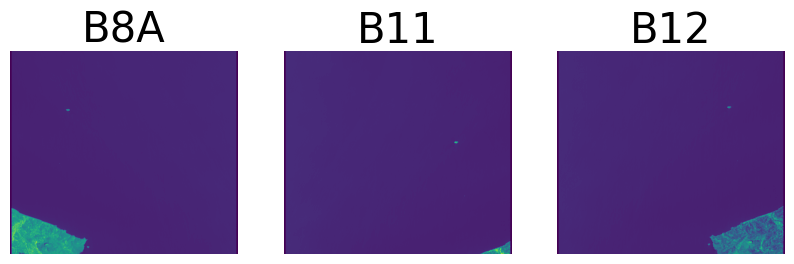

In [11]:
raw_granule=event.get_granule(0)
raw_granule.show_bands(downsampling=True)

# 4) - Compose granules

The APIs offer utils to compose granules along and across track. However, the granules from an event cannot composed arbitrarily. Indeed, to compose two granules **along track** they must have the same **detector number** and the **sensing-time** to be different of 3.6 s (3 or 4 seconds). For the event `Etna_00`, granules [0,2], [1,3], [3,5] can be stacked along tracks. <br> The next line will stack granules [0,2] along track. The string "T" means that the granule 0 will be stacked on top of 2. 

In [12]:
raw_granule_0_2_stacked=event.stack_granules([0,2], "T")

**Showing stacked granule info.** <br> By using the method `get_granule_info()` of the classs `raw_granule`, you can get the granule information. You can see that granule is now marked as **not original** (`originality` is set to `False`).
This is because the `raw_granule_0_2_stacked` is the result of combination of two granules. In this case, the `get_granule_info()` function will show will print `sensing time`, `acquisition time`, `detector number` for the granule parents. `originality` will be `False` and the list of granules parents will be not `None`. <br> <br> You can notice that the granule name is composed by the parents'name separated by the keyword **__STACKED_T__**, where **T** means the first granule is stacked at the top of the second one.

In [13]:
raw_granule_0_2_stacked.show_granule_info()

------------------Granule ----------------------------
Name:  S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091945_D06_N02.07_STACKED_T_S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091949_D06_N02.07
Sensing time:  [datetime.datetime(2019, 7, 5, 9, 19, 45), datetime.datetime(2019, 7, 5, 9, 19, 49)]
Creation time:  [datetime.datetime(2019, 7, 5, 11, 6, 5), datetime.datetime(2019, 7, 5, 11, 6, 5)]
Detector number:  [6, 6]
Originality:  False
Parents:  ['S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091945_D06_N02.07', 'S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091949_D06_N02.07']
Polygon coordinates: 

	P_0 : [38.8595942065205, 24.2363774063344]

	P_1 : [38.2853422451314, 24.0555738333442]

	P_2 : [38.2316646299934, 24.3371588011672]

	P_3 : [38.8054668607323, 24.5203827883621]

Cloud coverage:  [[0.0], [0.0]]




The same effect can be used by using the `Raw_event` method `get_stackable_granules()`, which permits extracting the couples of granules that can be stacked along-track automatically.

In [14]:
stackable_granules, stackable_couples=event.stack_granules_couples()
raw_granule_0_2_stacked=stackable_granules[0]
raw_granule_0_2_stacked.show_granule_info()

------------------Granule ----------------------------
Name:  S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091945_D06_N02.07_STACKED_T_S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091949_D06_N02.07
Sensing time:  [datetime.datetime(2019, 7, 5, 9, 19, 45), datetime.datetime(2019, 7, 5, 9, 19, 49)]
Creation time:  [datetime.datetime(2019, 7, 5, 11, 6, 5), datetime.datetime(2019, 7, 5, 11, 6, 5)]
Detector number:  [6, 6]
Originality:  False
Parents:  ['S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091945_D06_N02.07', 'S2A_OPER_MSI_L0__GR_MTI__20190705T110652_S20190705T091949_D06_N02.07']
Polygon coordinates: 

	P_0 : [38.8595942065205, 24.2363774063344]

	P_1 : [38.2853422451314, 24.0555738333442]

	P_2 : [38.2316646299934, 24.3371588011672]

	P_3 : [38.8054668607323, 24.5203827883621]

Cloud coverage:  [[0.0], [0.0]]




You can now see by superimposing the bands of stacked granules. As you can see that bands do not look coregistered. This is because the pushbroom nature of Sentinel-2, for which every band is looking at different areas during a single acquisition (granule) (and `SWIR` and `visible` bands are respectively rotated). 

Bands shifts:  [[-183.0, 12.0], [15.0, 12.0]]


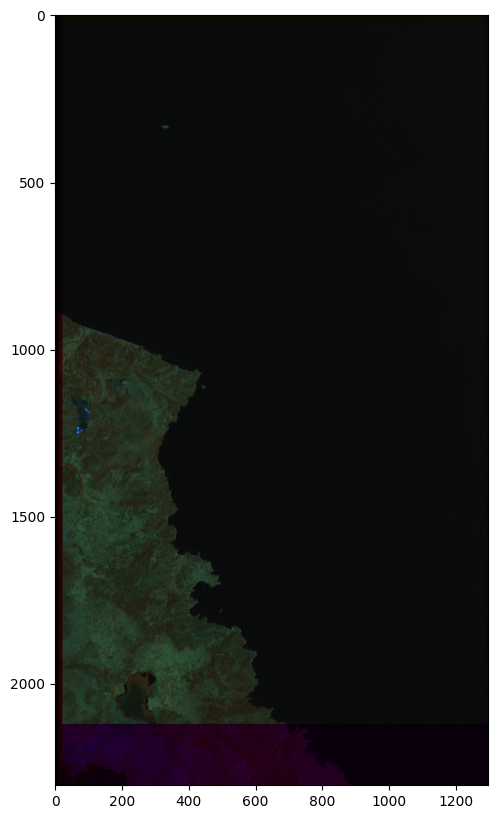

In [15]:
raw_granule_0_2_stacked.coarse_coregistration(crop_empty_pixels=False, verbose=True).show_bands_superimposition(equalize=False)

In [16]:
raw_granule_0_2_stacked.coarse_coregistration_old(crop_empty_pixels=True, verbose=True).show_bands_superimposition(equalize=False)

AttributeError: 'Raw_granule' object has no attribute 'coarse_coregistration_old'

# 5) - Coarse bands coregistration

In some cases, the **event** (*fire/volcanic eruption*) will be not contained in a single granule. In other cases, if the eruption is located close to the top/bottom margin, the information of some of the bands could be missing because of lack of bands registration. <br> Therefore, we stack to granules **along track** to try to overcome to this limitation.

**Bands can now be roughly coregistered**. <br> Coregistration is perfomed by shifting the bands of a number of pixel S_{k,l}|_{(S,D)}=$[N_{B_k,B_l}, M_{B_k,B_l}]|_{(S,D)}$ specific for the couple of bands $(B_k,B_l)$ produced by the detector having detector number $D$ in the satellite $S$ (S2A or S2B). $N_{B_k,B_l}$ is the number of along-track shift pixels, used to compensate the systematic band shifts due to the pushbroom nature of the sensor. Similarly, $M_{B_k,B_l}$ is the average number of across-track pixels in the `THRAW` dataset for a certain couple $(S,D)$. <br> To this aim, $S_{k,l}|_{(S,D)}$ are stored in a `Look Up Table` and used regardelss the position of the satellite. <br> It shall be noted that $S_{k,l}|_{(S,D)}$ indicates the number of pixels shift for which the band $B_l$ shall be moved to match the band $B_k$. Since $(B_k,B_l)$ could have different resolution, $S_{k,l}|_{(S,D)}$ is expressed with respect to $B_l$ resolution. <br>
Having more than 2 bands leads to coregister al the bands with respect to the first one. For instance, when using [`B8A`, `B11`,`B12`] bands `B12` and `B11` are coregistered with respect to `B8A`. <br>

The next line extracts the granule 2 from the event and performs the coregistration.

In [17]:
# Get granule 2
raw_granule=event.get_granule(2)
# Get granule 2 from the Raw event and perform coarse coregistration
raw_granule_registered=event.coarse_coregistration(granules_idx=[2])

Showing unregistered vs coarse registered granule.

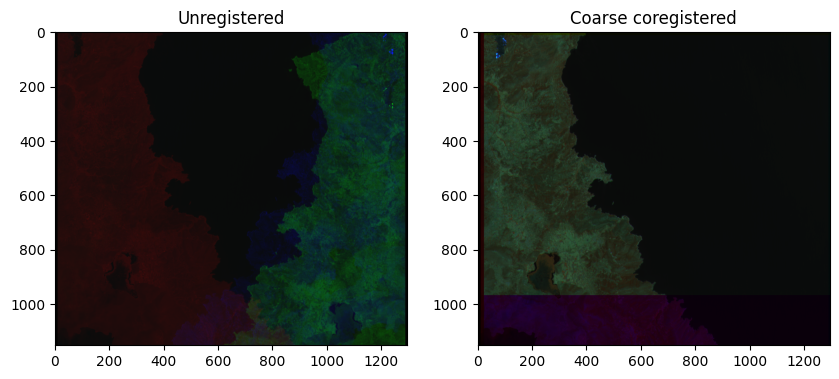

In [18]:
# Plotting unregistered vs registered granule
fig, ax = plt.subplots(1,2)
ax[0].set_title("Unregistered")
raw_granule_tensor=raw_granule.as_tensor(downsampling=True)
# Plot normalizing on the max
ax[0].imshow(raw_granule_tensor/raw_granule_tensor.max())
ax[1].set_title("Coarse coregistered")
raw_granule_registered_tensor=raw_granule_registered.as_tensor(downsampling=True)
# Plot normalizing on the max
ax[1].imshow(raw_granule_registered_tensor/raw_granule_registered_tensor.max())
plt.show()

As you can see in the image above, on the bottom of the registered images there is an image where only one band is not null. This is due to the fact that `B11` and `B12` are shifted to match `B8A`, leaving some area uncovered. <br>
This could create a problem every time the **high temperature anomaly** (*fire/volcanic eruption*) will be placed in that area. To overcome to this limitation, it is possible to fill the missing pixels by filling the missing pixels with the ones of adjacent granules. <br> To this aim, you can call the `coarse_coregistration` function with the flag `use_complementary_granules` set to `True`. In this way, if appropriate adjacent filler granules are available, they will be retrieved and adjacent pixels used to fill the missing pixels. <br> FIlling will be performed across-track as well. 

In [19]:
# Get granule 2 from the Raw event and perform coarse coregistration with filling elements
raw_granule_registered_filled=event.coarse_coregistration(granules_idx=[2], use_complementary_granules=True)

As you can see in the image below, missing pixels are now filled.

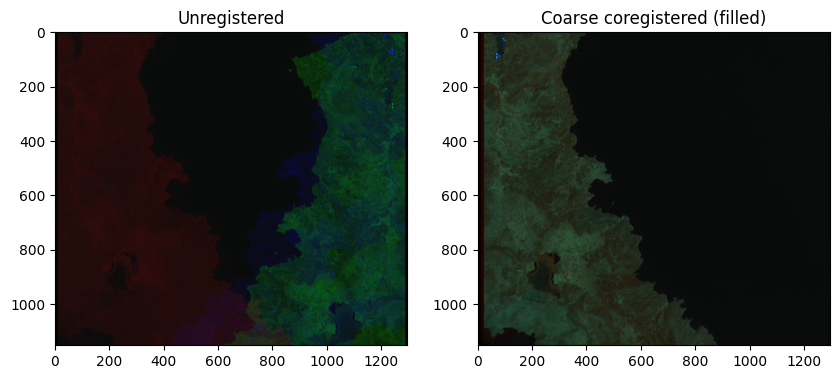

In [20]:
# Plotting unregistered vs registered granule
fig, ax = plt.subplots(1,2)
ax[0].set_title("Unregistered")
raw_granule_tensor=raw_granule.as_tensor(downsampling=True)
# Plot normalizing on the max
ax[0].imshow(raw_granule_tensor/raw_granule_tensor.max())
ax[1].set_title("Coarse coregistered (filled)")
raw_granule_registered_filled_tensor=raw_granule_registered_filled.as_tensor(downsampling=True)
# Plot normalizing on the max
ax[1].imshow(raw_granule_registered_filled_tensor/raw_granule_registered_filled_tensor.max())

Alternatively, it is also possible to crop those empty pixels. To this aim, you can call the  `coarse_coregistration` function with the flag `crop_empty_pixels` set to `True`.  If you set both the `use_complementary_granules` and `crop_empty_pixels` flags to `True`, filler elements will be used when available, otherwise missing pixels will be cropped.

In [21]:
# Get granule 2 from the L0 event and perform coarse coregistration with filling elements
raw_granule_registered_cropped=event.coarse_coregistration(granules_idx=[2], crop_empty_pixels=True)

The next plot shows all the possible cases.

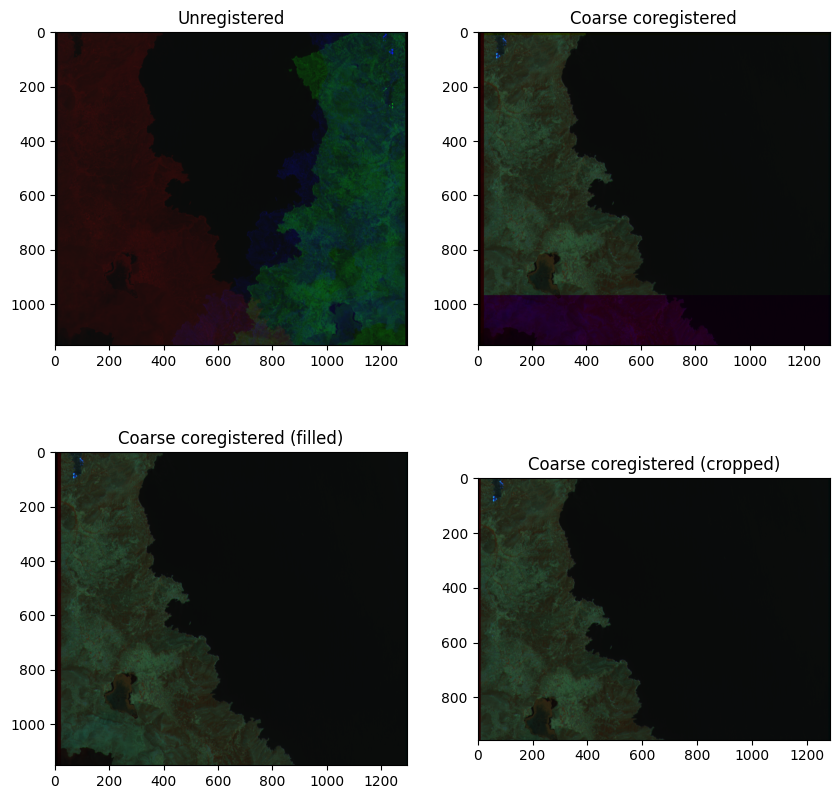

In [22]:
raw_granule_registered_cropped_tensor=raw_granule_registered_cropped.as_tensor(downsampling=True)
fig, ax = plt.subplots(2,2)
ax[0,0].set_title("Unregistered")
ax[0,0].imshow(raw_granule_tensor/raw_granule_tensor.max())
ax[0,1].set_title("Coarse coregistered")
# Plot normalizing on the max
ax[0,1].imshow(raw_granule_registered_tensor/raw_granule_registered_tensor.max())
ax[1,0].set_title("Coarse coregistered (filled)")
ax[1,0].imshow(raw_granule_registered_filled_tensor/raw_granule_registered_filled_tensor.max())
ax[1,1].set_title("Coarse coregistered (cropped)")
ax[1,1].imshow(raw_granule_registered_cropped_tensor/raw_granule_registered_cropped_tensor.max())
plt.show()

## 6) - Getting Raw granule and bands coordinates

***Get image coordinates.***

Granules coordinates are stored `InventoryMetadata.xml`. The ploygon represents the `Granule Footprint`, meaning the area covered by all the bands of one detector. <br> The next lines extract the granule 2 from the Raw_event and performs the coregistration with filling elements. Then, it extract the coordinates of the entire granule.

In [23]:
raw_granule_coregistered=event.coarse_coregistration(granules_idx=[2], use_complementary_granules=True, downsampling=False)
coordinates=raw_granule_coregistered.get_granule_coordinates()

The next lines show the area covered by the granule.

/var/folders/wk/ppkwh92d4hb_1fqwtwsw63n80000gn/T/ipykernel_11714/2038014853.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


Address:  Κύμη, Kymi - Aliveri Anna Municipality, Euboea Regional Unit, Central Greece, Thessaly and Central Greece, 340 03, Greece


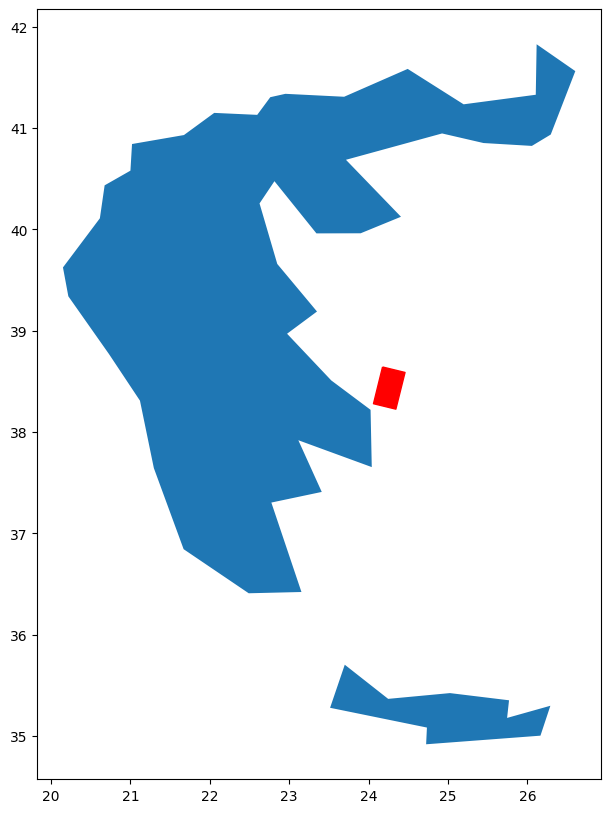

In [24]:
def plot_granule_coordinates(coordinates):
    try:
        world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
        world=world.to_crs("EPSG:4326")
        geolocator = Nominatim(user_agent="google")
        reverse = partial(geolocator.reverse, language="en")
        address=reverse(coordinates[0])[0]
        country=address[-address[::-1].find(","):][1:]
        coordinates=[(y,x) for (x,y) in coordinates]
        poly=GeoSeries([Polygon([x for x in coordinates +[coordinates[0]]])])
        poly=poly.set_crs("EPSG:4326")
        ax=world.query('name == \"'+country+'\"').plot()
        poly.plot(facecolor='red', edgecolor='red',ax=ax)
        print("Address: ", colored(address, "red"))
    except:
        print("Impossible to plot granule over the requested area.")
        
plot_granule_coordinates(coordinates)

Moreover, it is also possible to perform georeferencing of the single bands. <br> The next lines shows how to get the coordinates of the coregistered bands.

In [25]:
band_shifted_dict=raw_granule_coregistered.get_bands_coordinates()
band_shifted_dict

{'B8A': [(38.31623557480767, 24.06529480369464),
  (38.2625266369795, 24.347015644611776),
  (38.47415182774133, 24.41460542823174),
  (38.528075549730694, 24.131952886097636),
  (38.31623557480767, 24.06529480369464)],
 'B11': [(38.349887237490755, 24.075883717826365),
  (38.29614418030364, 24.357752563363906),
  (38.50776937106547, 24.42534234698387),
  (38.56172721241378, 24.14254180022936),
  (38.349887237490755, 24.075883717826365)],
 'B12': [(38.31347724180086, 24.06442685991335),
  (38.25977110064146, 24.346135569304227),
  (38.47139629140329, 24.413725352924192),
  (38.525317216723884, 24.131084942316345),
  (38.31347724180086, 24.06442685991335)]}

Showing bands coregistered bands positions.

/var/folders/wk/ppkwh92d4hb_1fqwtwsw63n80000gn/T/ipykernel_11714/442976589.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


Address:  Κύμη, Kymi - Aliveri Anna Municipality, Euboea Regional Unit, Central Greece, Thessaly and Central Greece, 340 03, Greece


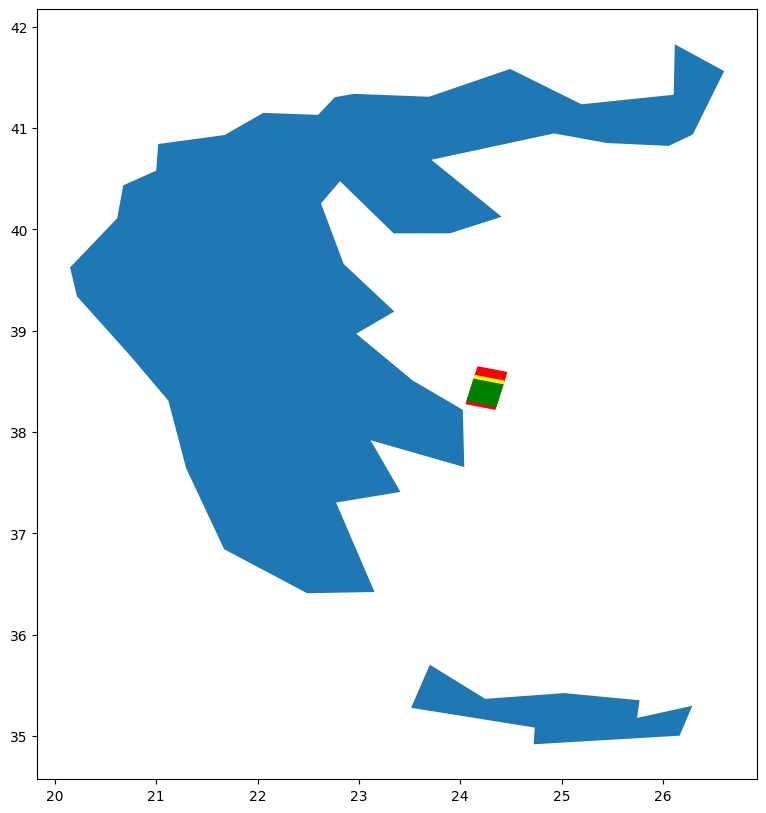

In [26]:
def plot_granule_coordinates(coordinates, coordinates_shifted_dict):
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world=world.to_crs("EPSG:4326")
    geolocator = Nominatim(user_agent="google")
    reverse = partial(geolocator.reverse, language="en")
    address=reverse(coordinates[0])[0]
    country=address[-address[::-1].find(","):][1:]
    coordinates=[(y,x) for (x,y) in coordinates]
    poly=GeoSeries([Polygon([x for x in coordinates +[coordinates[0]]])])
    poly=poly.set_crs("EPSG:4326")
    band_names=list(coordinates_shifted_dict.keys())
    color_mask=['blue', 'yellow', 'green']
    ax=world.query('name == \"'+country+'\"').plot()
    poly.plot(facecolor='red', edgecolor='red',ax=ax)
    
    for n in range(len(coordinates_shifted_dict)): 
        coordinates_shifted_band=coordinates_shifted_dict[band_names[n]]
        address_shifted=reverse(coordinates_shifted_dict[band_names[n]][0])[0]
        country_shifted=address_shifted[-address_shifted[::-1].find(","):][1:]
        coordinates_shifted_band=[(y,x) for (x,y) in coordinates_shifted_band]
        poly_shifted=GeoSeries([Polygon([x for x in coordinates_shifted_band +[coordinates_shifted_band[0]]])])
        poly_shifted.plot(facecolor=color_mask[n%3], edgecolor=color_mask[n%3],ax=ax)

    print("Address: ", colored(address, "red"))
        
plot_granule_coordinates(coordinates,band_shifted_dict)



To compare the coordinates of your the different bands, you can use the `create_geee_polygon` function and use the polygons on `Google Earth Engine` and visually compare them with respect the bands images and with respect to the polygon area.


In [27]:
def create_geee_polygon(coordinates, polygon_name, switch_lat_lon=True):
    if switch_lat_lon:
        pol_coordinates=[[y,x] for (x,y) in coordinates]
    else:
        pol_coordinates=coordinates
    pol_string="var "+polygon_name + " = ee.Geometry.Polygon("+str(pol_coordinates)+");"
    print(pol_string)
    return pol_string


# 7) - Open and crop L1C tiles

## 7.a) - Open L1C tiles and events

Getting `L1C` event corresponding to the `L0` event.

In [28]:
l1c_event=L1C_event(device=device)
l1c_event.from_database(event_name, requested_bands)

Parsing tiles...: 0it [00:00, ?it/s]

Taking band: B8A


Taking band: B11


Taking band: B12


Parsing sentinel bands: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]
Parsing tiles...: 1it [00:02,  2.95s/it]

Taking band: B8A


Taking band: B11


Taking band: B12


Parsing sentinel bands: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]
Parsing tiles...: 2it [00:05,  2.87s/it]


Printing `L1C` tiles info.

In [29]:
l1c_event.show_tiles_info()

------------------Tile 0 ----------------------------
Name:  S2A_MSIL1C_20190705T090601_N0207_R050_T34SGH_20190705T113504
Sensing time:  2019-07-05 11:35:04
Creation time:  2019-07-05 09:06:01
Corners coordinates: 

	P_0 : [38.826281708269896, 23.272364192591976]

	P_1 : [37.80678570689776, 23.272364192591976]

	P_2 : [37.80678570689776, 24.56639488157063]

	P_3 : [38.826281708269896, 24.56639488157063]



Footprint's coordinates: 

	P_0 : ['38.82628170870513', '23.303470403112804']

	P_1 : ['38.79452724007538', '24.566452796705864']

	P_2 : ['37.80685703267152', '24.518362240005832']

	P_3 : ['37.83751218570364', '23.272364192599564']



------------------Tile 1 ----------------------------
Name:  S2A_MSIL1C_20190705T090601_N0207_R050_T35SKC_20190705T113504
Sensing time:  2019-07-05 11:35:04
Creation time:  2019-07-05 09:06:01
Corners coordinates: 

	P_0 : [38.82843976038714, 23.545497035920942]

	P_1 : [37.810151149892924, 23.545497035920942]

	P_2 : [37.810151149892924, 24.838203338

## 7.b) Mosaicing and cropping L1C tiles on an L0 band coordinates.

It is now possible to mosaic L1C tiles and crop them over the area of the previous L0 granules. In this way, it is possible to process L1C tiles and reproject the retrieved information (e.g., event bounding boxes) on the correspondent L0 granule.  <br> The cropped L1C file is a "TIF" file. An `ending` is added to keep track of the indices of the granules used(i.e. ending = "2").

In [30]:
ending="2"
output_cropped_tile_path=l1c_event.crop_tile(band_shifted_dict[requested_bands[0]], None,out_name_ending=ending, lat_lon_format=True)

In [31]:
output_cropped_tile_path

'/Users/francesco/Desktop/pyraws/PyRawS/data/THRAWS/l1c/l1c_cropped_tif/Greece_5_2.tif'

Plotting results.

**Raw granule**

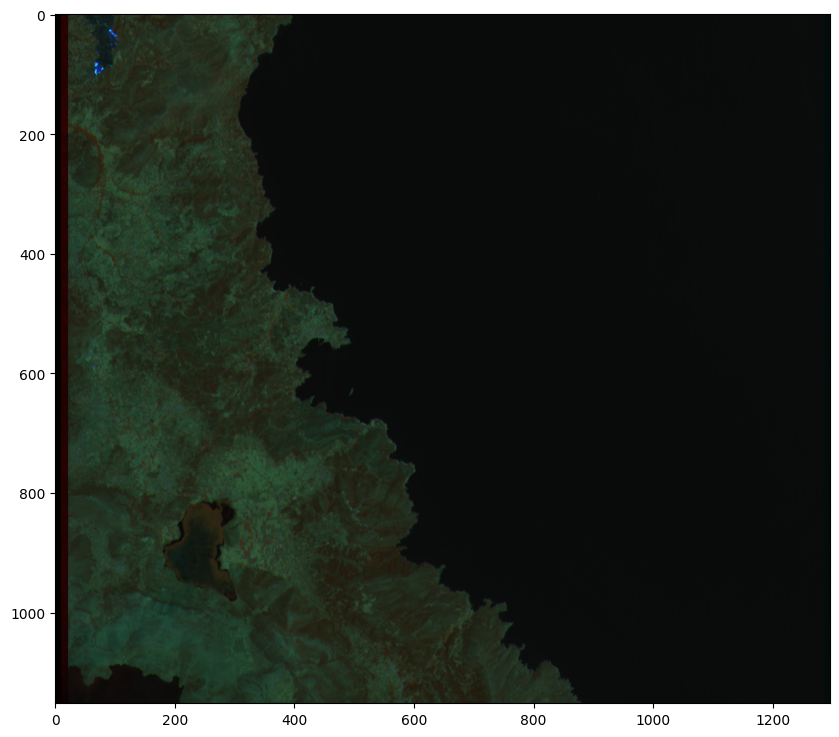

In [32]:
raw_granule_coregistered.show_bands_superimposition()

**L1C cropped tile**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4699].


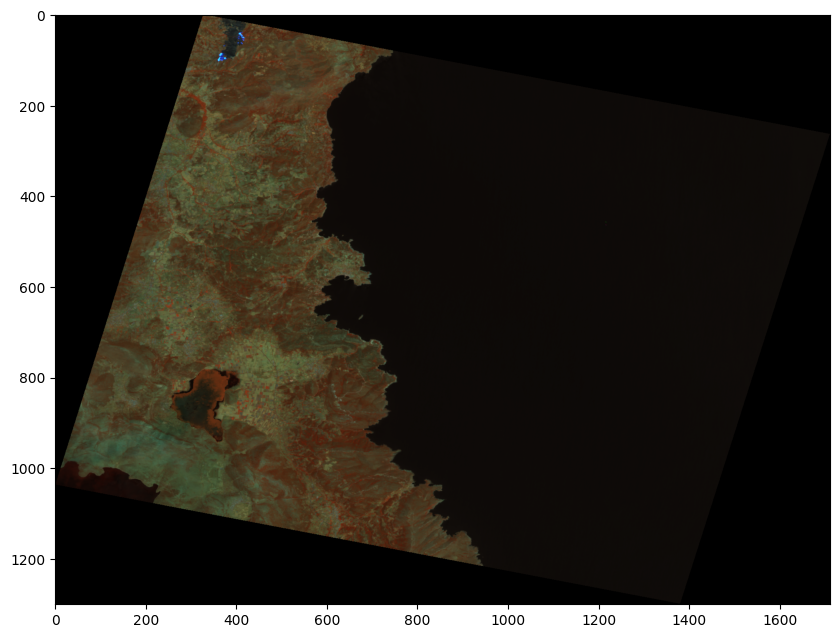

In [33]:
l1c_tif, coords_dict, expected_class=read_L1C_image_from_tif(event_name, ending, device=device)
plt.imshow(l1c_tif)

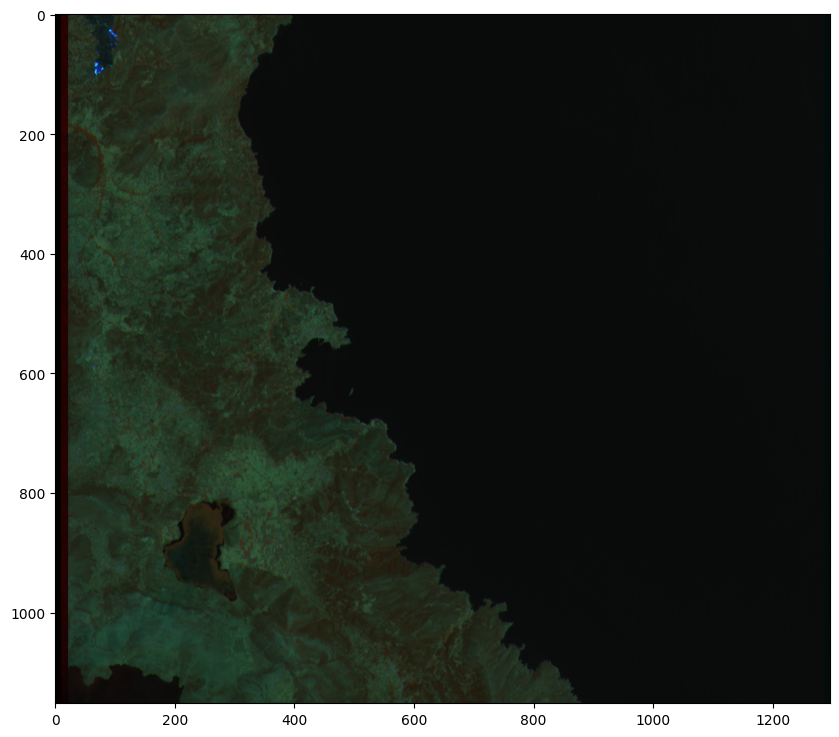

In [34]:
raw_granule_coregistered.show_bands_superimposition()

# 8) - Processing L1C tiles 

It is now possible to process the cropped `L1C` data to spot a volcanic eruption by using a simplified version of the algorithm [Massimetti, Francesco, et al.](https://www.mdpi.com/2072-4292/12/5/820). 

Get **hotmap**.

In [35]:
_, l1c_filtered_alert_matrix, l1c_alert_matrix=s2pix_detector(l1c_tif)

/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/API_demonstration/../../scripts_and_studies/hta_detection_algorithms/s2pix_detector.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img_pad, dtype=torch.float32, device=img_pad.device)
/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/API_demonstration/../../scripts_and_studies/hta_detection_algorithms/s2pix_detector.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv(torch.tensor(img_pad, dtype=torch.float32).unsqueeze(0).unsqueeze(0))


Show **alert matrix** and **filtered_alert_map**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4699].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4699].


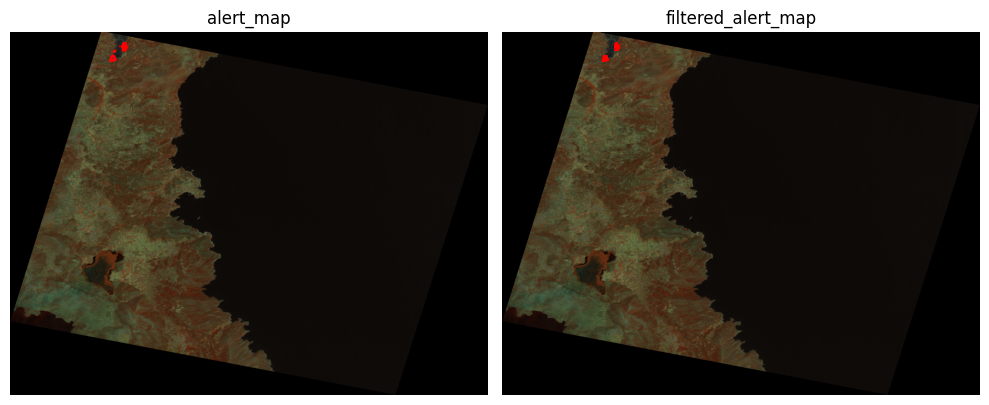

In [36]:
plot_img1_vs_img2_bands(l1c_tif, l1c_tif, ["alert_map", "filtered_alert_map"], l1c_alert_matrix, l1c_filtered_alert_matrix)

Show ***Raw granule*** and equivalent ***L1C cropped area*** with the correspondent ***filtere_alert_map***.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4699].


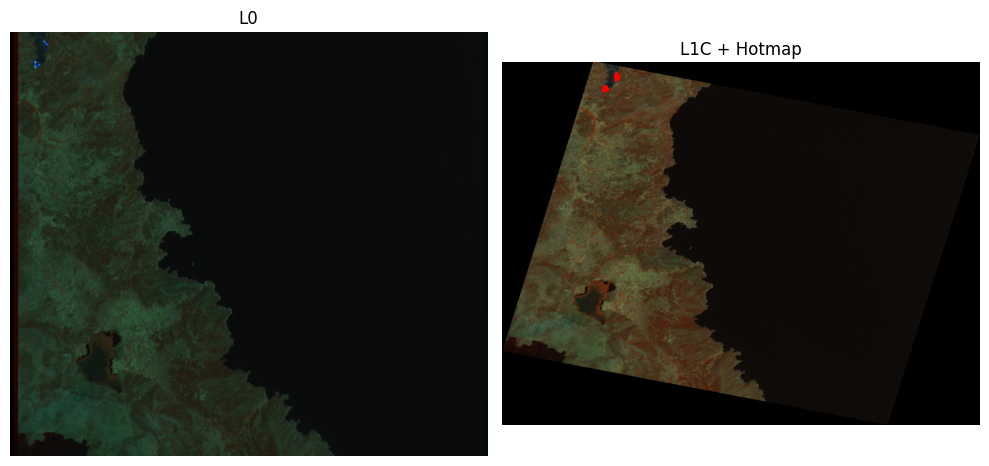

In [37]:
raw_granule_tensor=raw_granule_coregistered.as_tensor()
plot_img1_vs_img2_bands(raw_granule_tensor/raw_granule_tensor.max(), l1c_tif, ["L0", "L1C + Hotmap"], None, l1c_filtered_alert_matrix)

Show  ***L1C cropped area*** with the correspondent ***filtere_alert_map*** and ***bounding boxes***.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4699].


Found bbox (41, 404, 55, 417)
Found bbox (56, 415, 58, 417)
Found bbox (63, 404, 64, 405)
Found bbox (63, 411, 64, 412)
Found bbox (86, 360, 103, 378)


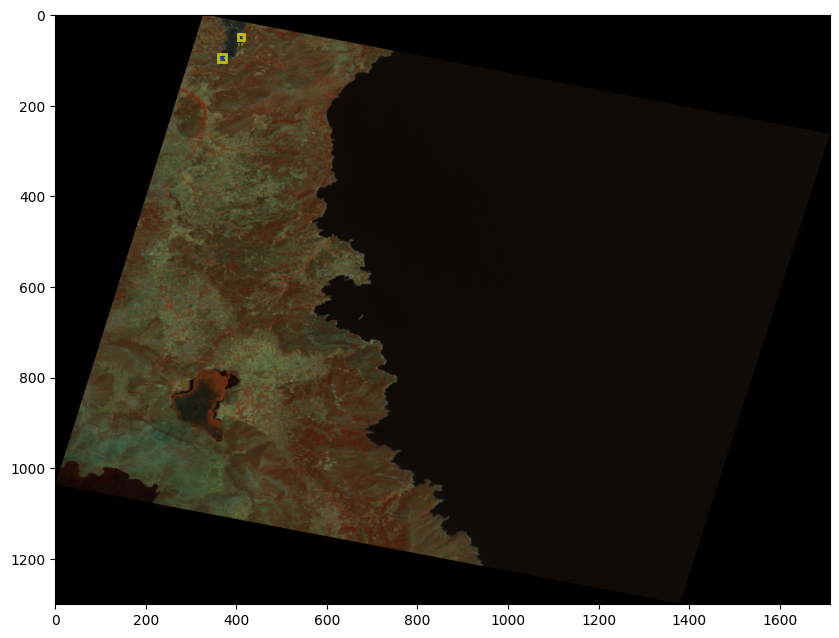

In [40]:
mask=l1c_filtered_alert_matrix.numpy()
lbl = label(mask)
props = regionprops(lbl)
l1c_numpy=l1c_tif.numpy()
fig, ax = plt.subplots()
ax.imshow(l1c_tif)
for prop in props:
     print('Found bbox', prop.bbox)
     bbox = prop.bbox         #   x,       y,        width, height
     rect = patches.Rectangle((bbox[1], bbox[0]), abs(bbox[1]-bbox[3]), abs(bbox[0]-bbox[2]), linewidth=2, edgecolor='y', facecolor='none')
     ax.add_patch(rect)
plt.show()

# 9) - Export L1C and Raw image for bounding box projections

To actually see how to project the founded bbox move to the [lightglue_homography](../BBOX_L1C2RAW/lightglue_homography.ipynb.ipynb) notebook

In [41]:
from torchvision.utils import save_image
raw_tensor = raw_granule_coregistered.as_tensor()
save_image((raw_tensor/raw_tensor.max()).permute(2, 0, 1),f"../BBOX_L1C2RAW/tests/raw_{event_name}.jpg","jpeg")
save_image(l1c_tif.permute(2, 0, 1),f"../BBOX_L1C2RAW/tests/l1c_{event_name}.jpg","jpeg")